**IMPORTING LIBRARIES**

In [94]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import regularizers

**CREATING IMAGE PATHS**

In [95]:
import os
import zipfile
#load data from archive.zip horse or human prediction import zipfile

# Define the path to the zip file
zip_file_path ='C:\\Users\\Dell\\Desktop\\from_scratch\\archive.zip'

# Define the path to the directory where you want to extract the contents of the zip file
extract_dir = 'C:\\Users\\Dell\\Desktop\\from_scratch\\dataset'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

train_dir = os.path.join(extract_dir, 'horse-or-human', 'train')
validation_dir = os.path.join(extract_dir, 'horse-or-human', 'validation')

**Preprocessing and Augmenting the Data**

In [96]:
train_gen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_gen= ImageDataGenerator(rescale=1./255.)

In [98]:
train_data = train_gen.flow_from_directory(train_dir, target_size=(150,150), batch_size=64, class_mode='binary')
validation_data = validation_gen.flow_from_directory(validation_dir, target_size=(150,150), batch_size=32, class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [99]:
# Get the first batch of images and labels from the generator
images, labels = next(train_data)

# Get the shape of the first image in the batch
sample_shape = images[0].shape

print("Shape of a sample from train_data:", sample_shape)

Shape of a sample from train_data: (150, 150, 3)


**Custom callback function when validation accuracy reaches 92%**

In [100]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if(logs.get('val_accuracy') >= 0.92):
            print("\nReached 92% validation accuracy so cancelling training!")
            self.model.stop_training = True

**AlexNET Model**

In [103]:
model = tf.keras.models.Sequential()

# Add the resizing layer
model.add(layers.Resizing(224, 224, interpolation="bilinear", input_shape=(150, 150, 3)))

# Add the convolutional layers
model.add(layers.Conv2D(96, 11, strides=4, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(3, strides=2))

model.add(layers.Conv2D(256, 5, strides=1, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(3, strides=2))

model.add(layers.Conv2D(384, 3, strides=1, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(384, 3, strides=1, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(256, 3, strides=1, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

# Add the global average pooling layer
model.add(layers.GlobalAveragePooling2D())

# Add the dense layers
model.add(layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

custom_callback = CustomCallback()

In [104]:
history = model.fit(train_data, validation_data=validation_data, epochs=100, callbacks=[custom_callback])


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.5508 - loss: 33.9003 - val_accuracy: 0.5000 - val_loss: 77.6194
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7449 - loss: 5.9593 - val_accuracy: 0.5000 - val_loss: 94.5456
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7950 - loss: 1.9760 - val_accuracy: 0.5000 - val_loss: 20.4079
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8202 - loss: 1.0112 - val_accuracy: 0.5000 - val_loss: 1.5987
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8863 - loss: 0.5764 - val_accuracy: 0.5000 - val_loss: 1.2947
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8645 - loss: 0.5219 - val_accuracy: 0.5000 - val_loss: 37.8582
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8938 - loss: 0.4075 - val_accuracy: 0.5000 - val_loss: 22.0006
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9319 - loss: 0.2859 - val_accuracy: 0.50

In [105]:
# Evaluate the model on the validation data
score = model.evaluate(validation_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.9300 - loss: 0.2195
Test loss: 0.21088437736034393
Test accuracy: 0.9296875


**Analyzing Training and Validation loss per epoch**

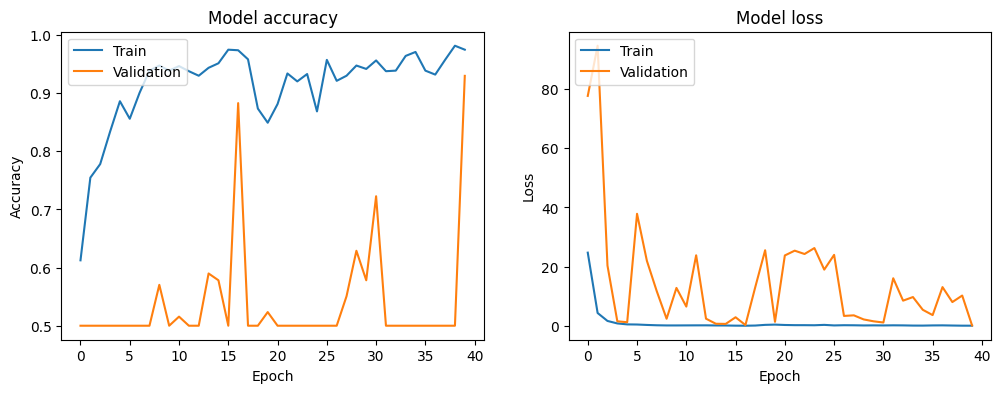

In [106]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()